In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F  

from torch.utils.data import DataLoader, TensorDataset
import gymnasium 
import mon_env
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [5]:
# Parameters
sequence_length = 4  # Number of images in each sequence
num_episodes = 3000   # Number of episodes for data collection


# Environment Setup
env = gymnasium.make('MonCartPole-v1', render_mode = 'rgb_array')
data_images = []
data_states = []

# Transformer les images et les convertir en tenseurs
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((60, 135)),
    transforms.Grayscale()
])

In [6]:
# Cart location for centering image crop
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# Cropping, downsampling (and Grayscaling) image
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Resize, and add a batch dimension (BCHW)
    return transform(screen.transpose(1,2,0)).squeeze(0)


In [7]:

# Collecter les données

for episode in range(num_episodes):
    observation = env.reset()[0] 
    images = [torch.zeros(60, 135) for _ in range(sequence_length)] # Initialisation avec images noires
    for t in range(1000):
        img = env.render()
        tensor_image = get_screen() # shape : 60x135
        # if t == 5:
        #     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  
        #     axes[0].imshow(tensor_image)
        
        images.append(tensor_image)
        sequence_tensor = torch.stack(images[-sequence_length:], dim=0) # shape : 4 x 60 x 135 (si sequence_length = 4)
        data_images.append(sequence_tensor)
        data_states.append(observation)

        action = env.action_space.sample()  
        observation, reward, done, info, _ = env.step(action)
        if done:
            break

env.close()

# Convert data_states to a tensor 
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Dans le dataloader : 
# images et labels associés. shape des images : 10 x 4 x 60 x 135
#                            shape des labels : 10 x 4 (10 = batch_size, 4 car (x,x_dot,theta,theta_dot))

C:\Users\hatem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.x_threshold to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x_threshold` for environment variables or `env.get_wrapper_attr('x_threshold')` that will search the reminding wrappers.
  logger.warn(
C:\Users\hatem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
C:\Users\hatem\AppData\Local\Temp\ipykernel_12676\1438530302.py:26: UserWarning: Creating a tensor

In [30]:
class CartPoleCNN(nn.Module):
    def __init__(self):
        super(CartPoleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(sequence_length, 16, kernel_size=5, stride=1, padding=2),  # Input: 4 gray images, output: 16 channels, 60x135
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: 30x67
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: 15x33
            # nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)                  # Output size: 7x16
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(15840, 128),
            nn.ReLU(),
            nn.Linear(128,4)    # x, x_dot, theta, theta_dot
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return x

# Instanciation du modèle
model = CartPoleCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([10, 4]) torch.Size([10, 4, 60, 135])
tensor([ 0.0986,  0.5630,  0.0026, -0.6533])


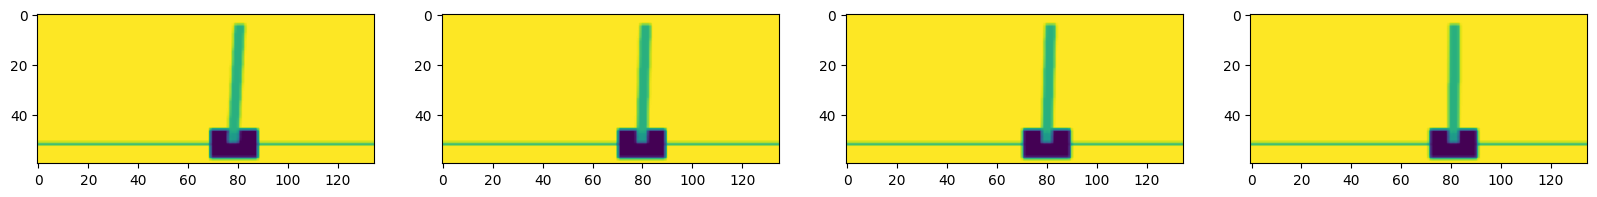

In [25]:
for images, labels in dataloader:
    print(labels.shape,images.shape) # (batch_size,4), (batch_size,sequence_length,60,135)
    fig,axes = plt.subplots(1,sequence_length,figsize = (20,30))
    for i in range(sequence_length):
        axes[i].imshow(images[0][i])
    print(labels[0])

    break

In [31]:
# Training Loop
num_epochs = 25 # Peut-être avec plus d'epoch on obtiendrait un meilleur résultat ? jsp
model.train()
for epoch in range(num_epochs):
    for images, states in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.11199275404214859
Epoch 2, Loss: 0.06364326179027557
Epoch 3, Loss: 0.020071031525731087
Epoch 4, Loss: 0.05183423310518265
Epoch 5, Loss: 0.03407881408929825
Epoch 6, Loss: 0.031121596693992615
Epoch 7, Loss: 0.016564620658755302
Epoch 8, Loss: 0.052262041717767715
Epoch 9, Loss: 0.016239451244473457
Epoch 10, Loss: 0.0683538094162941
Epoch 11, Loss: 0.03447888046503067
Epoch 12, Loss: 0.04580215364694595
Epoch 13, Loss: 0.01716875471174717
Epoch 14, Loss: 0.01932472176849842
Epoch 15, Loss: 0.01234764326363802
Epoch 16, Loss: 0.038950901478528976
Epoch 17, Loss: 0.02717047929763794
Epoch 18, Loss: 0.02766195312142372
Epoch 19, Loss: 0.033405084162950516
Epoch 20, Loss: 0.02635957859456539
Epoch 21, Loss: 0.03088177926838398
Epoch 22, Loss: 0.03457565978169441
Epoch 23, Loss: 0.019625620916485786
Epoch 24, Loss: 0.018856866285204887
Epoch 25, Loss: 0.017579110339283943
Epoch 26, Loss: 0.01820266619324684
Epoch 27, Loss: 0.04282165691256523
Epoch 28, Loss: 0.0079899709

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'big_model.pth')

In [32]:
model.eval()

for images, labels in dataloader:
    with torch.no_grad():
        print(model(images),labels)
    break



tensor([[-0.0092, -0.9540,  0.0486,  1.4971],
        [-0.0357, -0.0229,  0.1048,  0.3178],
        [ 0.0239, -0.2082, -0.0146,  0.3355],
        [-0.0185, -0.4558, -0.0187,  0.5941],
        [-0.0435, -0.0369, -0.0542, -0.1362],
        [-0.0636,  0.1759,  0.0462, -0.1915],
        [ 0.2299,  0.5334,  0.0527,  0.0604],
        [ 0.0601, -0.0400, -0.0620,  0.1555],
        [-0.0750,  0.0388,  0.1127,  0.2067],
        [ 0.0088, -0.1738, -0.0764, -0.1388]]) tensor([[-0.0143, -0.9412,  0.0528,  1.4701],
        [-0.0348, -0.0212,  0.1052,  0.3179],
        [ 0.0211, -0.2158, -0.0181,  0.3296],
        [-0.0234, -0.4372, -0.0156,  0.5839],
        [-0.0416, -0.0287, -0.0545, -0.1491],
        [-0.0674,  0.1740,  0.0512, -0.1989],
        [ 0.2192,  0.5393,  0.0624,  0.0577],
        [ 0.0585, -0.0374, -0.0562,  0.1533],
        [-0.0784,  0.0382,  0.1062,  0.1937],
        [ 0.0088, -0.1547, -0.0760, -0.1607]])


In [33]:
# Voir encore mieux ce que ça donne

# 1 : On collecte des images du cartpole (heuristique : random)

env = gymnasium.make('CartPole-v1', render_mode = 'rgb_array')
data_images_bis = []
data_states_bis = []

for episode in range(3):
    observation_bis = env.reset()[0]
    images_bis = []
    for t in range(1000):
        img = env.render()
        tensor_image = transform(img).squeeze(0)  # Transform image immediately
        images_bis.append(tensor_image)
        
        if len(images_bis) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images_bis[-sequence_length:], dim=0)
            data_images_bis.append(sequence_tensor)
            data_states_bis.append(observation)
        
        action = env.action_space.sample()   # Use the heuristic policy
        observation, reward, done, info, _ = env.step(action)
        if done:
            break
data_states_bis = torch.tensor(data_states_bis, dtype=torch.float32)

# Dataset and DataLoader
data_images_bis = torch.stack(data_images_bis)

In [35]:
# 2 Afficher ce que prédit le modèle vs les vraies observations

model.eval()
total = 0 # Loss totale
for images, states in zip(data_images_bis, data_states_bis):
    with torch.no_grad():
        print(model(images.unsqueeze(0)),states)
        total += np.sum(np.array((model(images.unsqueeze(0))-states)**2))

print(total)

tensor([[0.0761, 0.0623, 0.0388, 0.2811]]) tensor([ 0.0437, -0.2364,  0.0307,  0.2813])
tensor([[0.0666, 0.0124, 0.0406, 0.3425]]) tensor([ 0.0389, -0.0417,  0.0363, -0.0016])
tensor([[0.0733, 0.0225, 0.0401, 0.3391]]) tensor([ 0.0381,  0.1529,  0.0363, -0.2826])
tensor([[0.0847, 0.0777, 0.0390, 0.2695]]) tensor([ 0.0412,  0.3475,  0.0306, -0.5636])
tensor([[0.0915, 0.1408, 0.0348, 0.1756]]) tensor([ 0.0481,  0.1519,  0.0193, -0.2614])
tensor([[0.0890, 0.1273, 0.0311, 0.1857]]) tensor([ 0.0512, -0.0435,  0.0141,  0.0373])
tensor([[0.0790, 0.0817, 0.0326, 0.2456]]) tensor([ 0.0503, -0.2388,  0.0149,  0.3344])
tensor([[0.0630, 0.0012, 0.0365, 0.3529]]) tensor([ 0.0455, -0.4341,  0.0215,  0.6317])
tensor([[ 0.0589, -0.0352,  0.0398,  0.4050]]) tensor([ 0.0368, -0.2393,  0.0342,  0.3459])
tensor([[ 0.0669, -0.0215,  0.0404,  0.3898]]) tensor([ 0.0320, -0.4349,  0.0411,  0.6491])
tensor([[ 0.0518, -0.0644,  0.0402,  0.4256]]) tensor([ 0.0233, -0.6306,  0.0541,  0.9545])
tensor([[ 0.0579, -0